## Data Preprocessing
Suprita Ashok

Following is the same data exploration data_exploration.ipynb

## Import Libraries and Dataset

In [4]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
! pip install transformers
! pip install pycaret

In [1]:
import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
device = torch.device("cuda")

In [5]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

# load datasets
tot = pd.read_csv(path+'/WELFake_Dataset.csv')
#fake=pd.read_csv(path+'/fake.csv')
#true=pd.read_csv(path+'/true.csv')
fake = tot[tot['label'] == 1]
true= tot[tot['label'] == 0]

Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77


## Preliminary Inspection and Word Clouds

- All/most of the true data was likely sourced from Reuters

In [6]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))

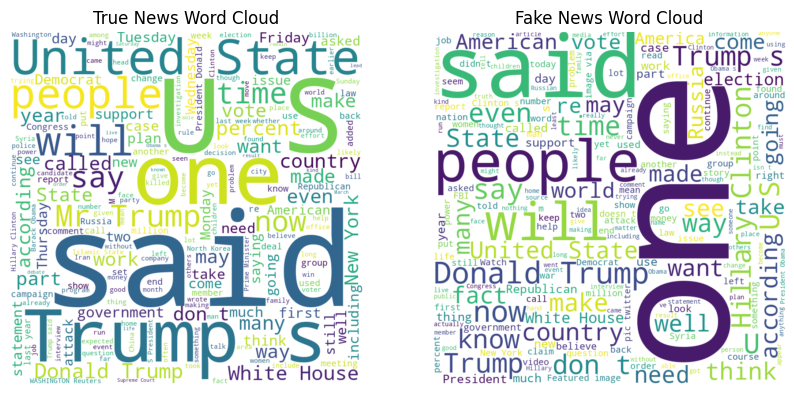

In [7]:


true_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_text)
fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.show()

In [8]:
true.head()

,Unnamed: 0,title,text,label
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
11,11,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0
12,12,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0
14,14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0
15,15,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0


In [9]:
true.tail()

,Unnamed: 0,title,text,label
72124,72124,An Unlikely Contender Rises in France as the A...,"PARIS — In the age of Donald J. Trump, “Bre...",0
72126,72126,Determined to kill: Can tough gun laws end mas...,The flag at Desert Hot Springs' Condor Gun Sho...,0
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [10]:
fake.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [11]:
fake.tail()

,Unnamed: 0,title,text,label
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,Judge Jeanine lets it rip! She s concerned wit...,1
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [12]:
true.drop("Unnamed: 0", axis = 1, inplace = True)
fake.drop("Unnamed: 0", axis = 1, inplace = True)

## Dataset Balance, Features, Missing Values, Duplicates

Summary of findings:
- The dataset is well balanced, with 35028 true news articles, and 37106 fake news articles
- There are four features: title, text, subject and date
- There are some instances of (NaN) data
- There are no articles without titles
- There are some articles without text
- There is some duplicate data: 237 duplicated true news articles, and 8109 duplicated fake news articles

The articles without titles and the duplicate articles were dropped from the datasets.

True news dataset shape: (35028, 3)
Fake news dataset shape: (37106, 3)


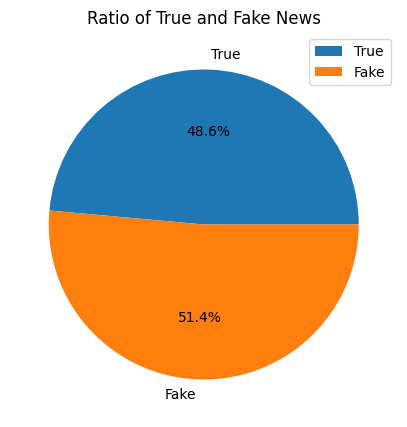

Features in 'True' Dataset:
 ['title', 'text', 'label'] 

Features in 'Fake' Dataset:
 ['title', 'text', 'label'] 



In [13]:
# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

# Graph pie chart displaying ratio of true and fake news
plt.figure(figsize=(5,5))
plt.title('Ratio of True and Fake News')
plt.axis('equal')
plt.pie([true.shape[0],fake.shape[0]],labels=['True','Fake'],autopct='%1.1f%%')
plt.legend()
plt.show()

# Print feature names (column names) for both datasets
print("Features in 'True' Dataset:\n", true.columns.tolist(), "\n")
print("Features in 'Fake' Dataset:\n", fake.columns.tolist(), "\n")

In [14]:
# Summary of blank and missing entries in true data
summary_true = {
    "Blank Text Entries": (true['text'].str.strip() == '').sum(),
    "Blank Title Entries": (true['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": true.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_true.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |       1 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [15]:
summary_fake = {
    "Blank Text Entries": (fake['text'].str.strip() == '').sum(),
    "Blank Title Entries": (fake['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": fake.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_fake.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |     743 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |     597 |
+----+-----------------------+---------+


In [16]:
# Identify duplicates for both datasets
true_duplicates = true.duplicated().sum()
fake_duplicates = fake.duplicated().sum()

print("Number of Duplicates in 'True' Dataset:", true_duplicates)
print("Number of Duplicates in 'Fake' Dataset:", fake_duplicates)

Number of Duplicates in 'True' Dataset: 237
Number of Duplicates in 'Fake' Dataset: 8219


In [17]:
# Drop duplicates
true = true.drop_duplicates()
fake = fake.drop_duplicates()

# Drop articles without text
indices = true[(true['text'].str.strip() == '')].index
true_cleaned = true.drop(indices)

indices = fake[(fake['text'].str.strip() == '')].index
fake_cleaned = fake.drop(indices)

# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

True news dataset shape: (34791, 3)
Fake news dataset shape: (28887, 3)


In [18]:
true['Target'] = ['True']*len(true)
fake['Target'] = ['Fake']*len(fake)

## Word Frequency Analysis (Text Only, Did Not Include Titles)

After dropping duplicate articles, the top ten most frequent words in text, after removing the most common stopwords, were identified for both true and fake news. Also, the top ten most divergent word frequencies between true and fake news were identified.


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


In [19]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))
all_text = [true_text, fake_text]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_text])
fake_counts = vectorizer.fit_transform([fake_text])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_text])
fake_counts = vectorizer.transform([fake_text])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [20]:
# Display top 10 most frequent words for true news
print("Top 10 Most Frequent Words in True News:")
print(tabulate(top_true.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News:
+----+------------+-------------+
|    | Word       |   Frequency |
+====+============+=============+
|  0 | said       |      183320 |
+----+------------+-------------+
|  1 | trump      |      106522 |
+----+------------+-------------+
|  2 | mr         |       66077 |
+----+------------+-------------+
|  3 | president  |       50955 |
+----+------------+-------------+
|  4 | new        |       42325 |
+----+------------+-------------+
|  5 | people     |       41551 |
+----+------------+-------------+
|  6 | state      |       38622 |
+----+------------+-------------+
|  7 | states     |       31414 |
+----+------------+-------------+
|  8 | government |       29800 |
+----+------------+-------------+
|  9 | reuters    |       29027 |
+----+------------+-------------+


In [21]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |       89573 |
+----+-----------+-------------+
|  1 | people    |       38509 |
+----+-----------+-------------+
|  2 | said      |       37351 |
+----+-----------+-------------+
|  3 | clinton   |       34058 |
+----+-----------+-------------+
|  4 | president |       29710 |
+----+-----------+-------------+
|  5 | just      |       27854 |
+----+-----------+-------------+
|  6 | like      |       25193 |
+----+-----------+-------------+
|  7 | hillary   |       23567 |
+----+-----------+-------------+
|  8 | new       |       21423 |
+----+-----------+-------------+
|  9 | obama     |       21279 |
+----+-----------+-------------+


Compare frequencies of words between true and fake news:

In [22]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words:")
print(tabulate(top_divergent.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words:
+----+-----------+------------------+------------------+--------------+
|    | Word      |   True_Frequency |   Fake_Frequency |   Difference |
+====+===========+==================+==================+==============+
|  0 | said      |           183320 |            37351 |       145969 |
+----+-----------+------------------+------------------+--------------+
|  1 | mr        |            66077 |             4711 |        61366 |
+----+-----------+------------------+------------------+--------------+
|  2 | reuters   |            29027 |              749 |        28278 |
+----+-----------+------------------+------------------+--------------+
|  3 | president |            50955 |            29710 |        21245 |
+----+-----------+------------------+------------------+--------------+
|  4 | new       |            42325 |            21423 |        20902 |
+----+-----------+------------------+------------------+--------------+
|  5 | state     |            38622

In [23]:
# Print list of top ten fake words
print("\nTop 10 Fake Words:")
print(top_fake.index.tolist())

# Print list of top ten true words
print("\nTop 10 True Words:")
print(top_true.index.tolist())

# Print list of top ten words
print("\nTop 10 Divergent Words:")
print(top_divergent.index.tolist())


Top 10 Fake Words:
['trump', 'people', 'said', 'clinton', 'president', 'just', 'like', 'hillary', 'new', 'obama']

Top 10 True Words:
['said', 'trump', 'mr', 'president', 'new', 'people', 'state', 'states', 'government', 'reuters']

Top 10 Divergent Words:
['said', 'mr', 'reuters', 'president', 'new', 'state', 'trump', 'states', 'united', 'house']


## Data Exploration (continued)
Vrinda Pandey

Below is an alaysis of the titles of True and Fake news examining the words, their usage, frequency and furthermore the ideas these words may imply in the recspecitve news pieces. At the end you can find a summary and ideas that should be further investigated

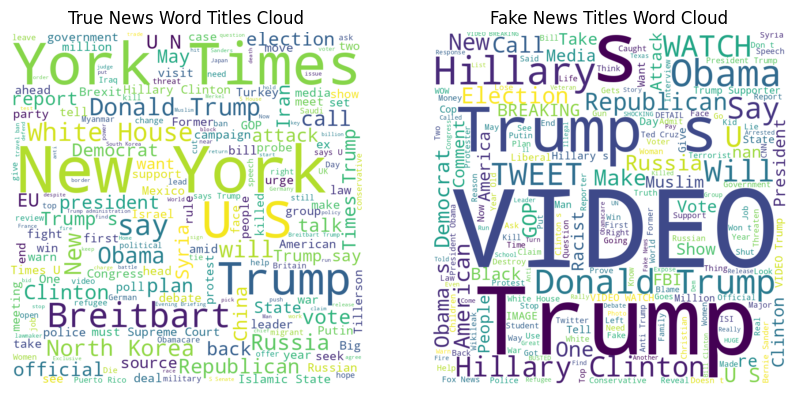

In [24]:
true_title = ' '.join(true['title'].astype(str))
fake_title = ' '.join(fake['title'].astype(str))

true_title_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_title)
fake_title_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_title)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Titles Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Titles Word Cloud')

plt.show()

In [25]:
all_text = [true_title, fake_title]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_title])
fake_counts = vectorizer.fit_transform([fake_title])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_title])
fake_counts = vectorizer.transform([fake_title])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true_titles = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake_titles = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [26]:
# Display top 10 most frequent words for true news titles
print("Top 10 Most Frequent Words in True News Titles:")
print(tabulate(top_true_titles.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News Titles:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |        8461 |
+----+-----------+-------------+
|  1 | new       |        7700 |
+----+-----------+-------------+
|  2 | york      |        6481 |
+----+-----------+-------------+
|  3 | times     |        6366 |
+----+-----------+-------------+
|  4 | says      |        3330 |
+----+-----------+-------------+
|  5 | breitbart |        2402 |
+----+-----------+-------------+
|  6 | house     |        1788 |
+----+-----------+-------------+
|  7 | clinton   |        1352 |
+----+-----------+-------------+
|  8 | obama     |        1253 |
+----+-----------+-------------+
|  9 | russia    |        1172 |
+----+-----------+-------------+


In [27]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake_titles.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+---------+-------------+
|    | Word    |   Frequency |
+====+=========+=============+
|  0 | trump   |        9330 |
+----+---------+-------------+
|  1 | video   |        6787 |
+----+---------+-------------+
|  2 | hillary |        2672 |
+----+---------+-------------+
|  3 | obama   |        2041 |
+----+---------+-------------+
|  4 | clinton |        1828 |
+----+---------+-------------+
|  5 | watch   |        1680 |
+----+---------+-------------+
|  6 | just    |        1508 |
+----+---------+-------------+
|  7 | new     |        1118 |
+----+---------+-------------+
|  8 | donald  |        1039 |
+----+---------+-------------+
|  9 | news    |        1012 |
+----+---------+-------------+


In [28]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent_title = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words in News Titles:")
print(tabulate(top_divergent_title.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words in News Titles:
+----+-----------+------------------+------------------+--------------+
|    | Word      |   True_Frequency |   Fake_Frequency |   Difference |
+====+===========+==================+==================+==============+
|  0 | new       |             7700 |             1118 |         6582 |
+----+-----------+------------------+------------------+--------------+
|  1 | york      |             6481 |              106 |         6375 |
+----+-----------+------------------+------------------+--------------+
|  2 | times     |             6366 |              161 |         6205 |
+----+-----------+------------------+------------------+--------------+
|  3 | says      |             3330 |              599 |         2731 |
+----+-----------+------------------+------------------+--------------+
|  4 | breitbart |             2402 |               42 |         2360 |
+----+-----------+------------------+------------------+--------------+
|  5 | house     |  

In [29]:
# Print list of top ten fake words in news titles
print("\nTop 10 Fake Words:")
print(top_fake_titles.index.tolist())

# Print list of top ten true words in news titles
print("\nTop 10 True Words:")
print(top_true_titles.index.tolist())

# Print list of top ten words in news titles
print("\nTop 10 Divergent Words:")
print(top_divergent_title.index.tolist())


Top 10 Fake Words:
['trump', 'video', 'hillary', 'obama', 'clinton', 'watch', 'just', 'new', 'donald', 'news']

Top 10 True Words:
['trump', 'new', 'york', 'times', 'says', 'breitbart', 'house', 'clinton', 'obama', 'russia']

Top 10 Divergent Words:
['new', 'york', 'times', 'says', 'breitbart', 'house', 'north', 'korea', 'china', 'senate']


Summary of findings:
-trump is apparently everyones favorite word regardless of fake or true news titles
-true news titleshas a higher frequency of foreign countries mentioned than fake news titles
-fake news has call to action words such as watch and video

Calls of Action:
-one of the top 10 most frequent words in true news titles is white while one of the top 10 most frequent words in fake news titles is black. What does this mean? Is it racial?
-it seemed as if fake news has call to action words such as watch and video. We should investigate if fake news has more of these action verbage as if its asking its audience to do something
-Since most/all true data is from Reuters would be interesting and probably relevant to identify any news biases that reuters has

## Sentiment Analysis

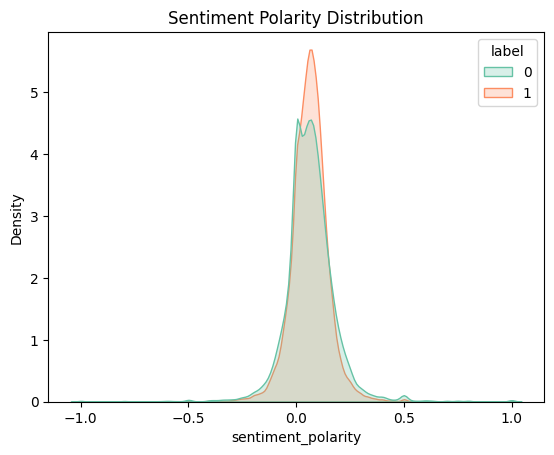

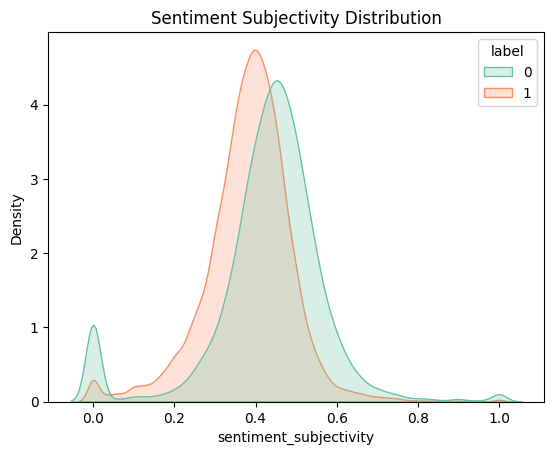

In [30]:
# Add sentiment scores
true['label'] = 1
fake['label'] = 0
all_news = pd.concat([true, fake], ignore_index=True)

all_news['sentiment_polarity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
all_news['sentiment_subjectivity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Compare polarity and subjectivity
sns.kdeplot(data=all_news, x='sentiment_polarity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Polarity Distribution")
plt.show()

sns.kdeplot(data=all_news, x='sentiment_subjectivity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Subjectivity Distribution")
plt.show()

In [31]:
all_news = all_news.sample(frac=1, random_state=42).reset_index(drop=True)
all_news.head()

,title,text,label,Target,sentiment_polarity,sentiment_subjectivity
0,Tillerson says China should be barred from Sou...,WASHINGTON (Reuters) - U.S. President-elect Do...,1,True,0.016389,0.443707
1,Bundy Case Ruled a Mistrial – Will Federal Cas...,Mark Anderson 21st Century WireThe Greek phil...,0,Fake,0.075481,0.402351
2,[WATCH] Hillary Appears Belligerently Drunk in...,0 comments \nHillary Clinton’s trouble staying...,0,Fake,0.081061,0.315613
3,"After Vets Fight War, Feds Demand Money Back","After Vets Fight War, Feds Demand Money Back U...",0,Fake,0.044444,0.311111
4,Wikileaks: CNN’s Donna Brazile Shared More Deb...,Videos Wikileaks: CNN’s Donna Brazile Shared M...,0,Fake,0.152412,0.472802


In [32]:
print(all_news.isnull().sum())  # Check for NaN in the training labels

title                     518
text                       39
label                       0
Target                      0
sentiment_polarity          0
sentiment_subjectivity      0
dtype: int64


In [33]:
all_news = all_news.dropna()

In [34]:
print(all_news.isnull().sum())

title                     0
text                      0
label                     0
Target                    0
sentiment_polarity        0
sentiment_subjectivity    0
dtype: int64


In [35]:
# Remove duplicate text entries based on the 'text' column
all_news = all_news.drop_duplicates(subset=['text']).reset_index(drop=True)
print(f"Dataset size after removing duplicate text entries: {all_news.shape}")

Dataset size after removing duplicate text entries: (62200, 6)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(all_news['text'], all_news['label'], test_size=0.2, random_state=42, stratify=all_news['label'])
overlap = set(X_train).intersection(set(X_test))
print(f"Number of overlapping samples between train and test sets: {len(overlap)}")

Number of overlapping samples between train and test sets: 0


In [37]:
all_news.shape, X_train.shape, X_test.shape

((62200, 6), (49760,), (12440,))

## Preprocessing with NLP

The above code causes the word "U.S." to be turned into "u.s".

The preprocessing needs to be done for all elements in the all_text pd

In [38]:
# clean text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Preserve words like U.S. by putting a special character there temporarily
    text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1specialdot', text) # Acronyms (U.S.)
    text = re.sub(r'\b([a-zA-Z])\.(?=\s|$)', r'\1specialdot', text)  # End of sentence

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Restore the periods in words like U.S.
    text = text.replace("specialdot", ".")
    text = re.sub(r'[^\w\s\.specialdot]', '', text)

    # Tokenize text
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text

def vectorize(text):
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1,1),
        stop_words='english'
    )
    X_tfidf = vectorizer.fit_transform(text)
    return X_tfidf, vectorizer




In [39]:
train_text, temp_text, train_labels, temp_labels = train_test_split(all_news['title'], all_news['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=all_news['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

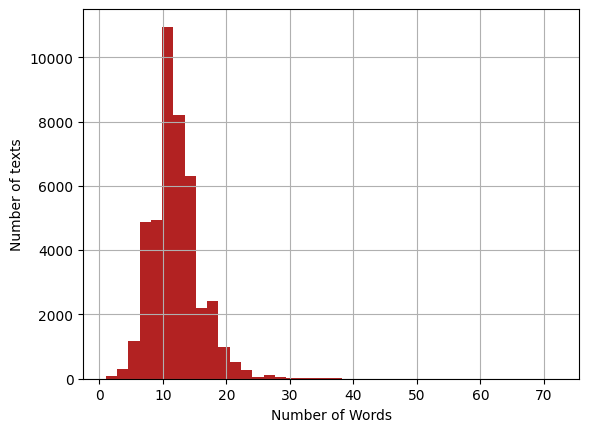

In [40]:

# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [41]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [42]:

# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [43]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x
model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

In [44]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [45]:

# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of  1,361.
  Batch   100  of  1,361.
  Batch   150  of  1,361.
  Batch   200  of  1,361.
  Batch   250  of  1,361.
  Batch   300  of  1,361.
  Batch   350  of  1,361.
  Batch   400  of  1,361.
  Batch   450  of  1,361.
  Batch   500  of  1,361.
  Batch   550  of  1,361.
  Batch   600  of  1,361.
  Batch   650  of  1,361.
  Batch   700  of  1,361.
  Batch   750  of  1,361.
  Batch   800  of  1,361.
  Batch   850  of  1,361.
  Batch   900  of  1,361.
  Batch   950  of  1,361.
  Batch 1,000  of  1,361.
  Batch 1,050  of  1,361.
  Batch 1,100  of  1,361.
  Batch 1,150  of  1,361.
  Batch 1,200  of  1,361.
  Batch 1,250  of  1,361.
  Batch 1,300  of  1,361.
  Batch 1,350  of  1,361.

Evaluating...
  Batch    50  of    292.
  Batch   100  of    292.
  Batch   150  of    292.
  Batch   200  of    292.
  Batch   250  of    292.

Training Loss: 0.625
Validation Loss: 0.593

 Epoch 2 / 2
  Batch    50  of  1,361.
  Batch   100  of  1,361.
  Batch   150  of  1,361.
  

In [46]:

# load weights of best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.77      0.48      0.59      4137
           1       0.68      0.89      0.77      5193

    accuracy                           0.71      9330
   macro avg       0.73      0.68      0.68      9330
weighted avg       0.72      0.71      0.69      9330



In [47]:
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]
# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
preds

array([0, 1, 1, 1])